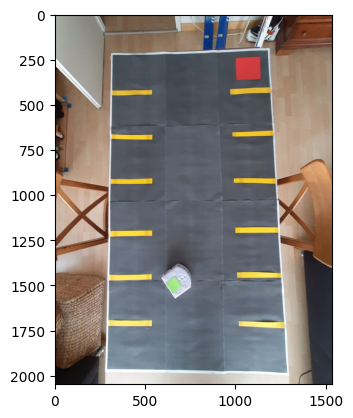

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('image_processing/test.jpeg', cv2.IMREAD_COLOR)
#img = cv2.imread('./test_images/WIN_20221122_20_34_38_Pro.jpg', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(img)
plt.show()

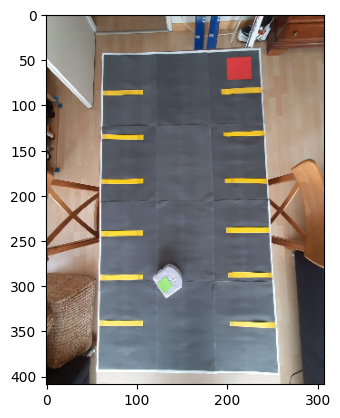

In [3]:
scale_percent = 20

width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dsize = (width, height)
output = cv2.resize(img, dsize)
plt.imshow(output)
plt.show()

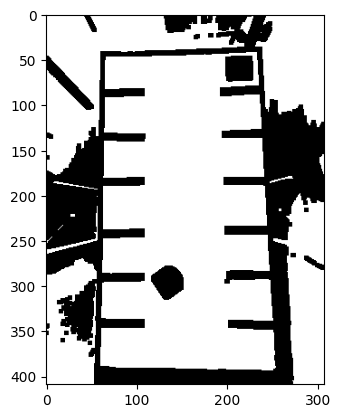

In [4]:
x0 = 180
lower_thld = np.array([0, 0, 0])
upper_thld = np.array([x0, x0, x0])

mask = cv2.inRange(output, lower_thld, upper_thld)
kernel = np.ones((5, 5), np.uint8)
mask = cv2.erode(mask, kernel)
plt.imshow(mask, cmap='gray')
plt.show()

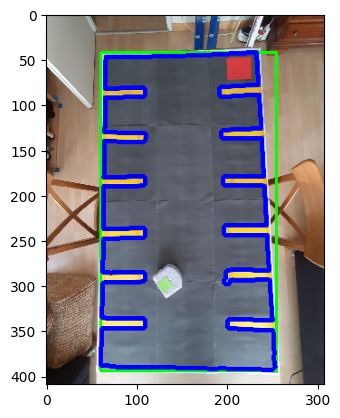

In [5]:
test = output.copy()
test2 = output.copy()
contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key = cv2.contourArea)

x,y,w,h = cv2.boundingRect(cnt)
cv2.rectangle(test,(x,y),(x+w,y+h),(0,255,0),2)
test = cv2.drawContours(test, [cnt], -1, (0, 0, 255), 3)
plt.imshow(test)
plt.show()

In [6]:
def order_points(pts):
    '''Rearrange coordinates to order:
      top-left, top-right, bottom-right, bottom-left'''
    rect = np.zeros((4, 2), dtype='float32')
    pts = np.array(pts)
    # Make sure contours array is 2d
    pts = np.squeeze(pts)
    s = pts.sum(axis=1)
    # Top-left point will have the smallest sum.
    rect[0] = pts[np.argmin(s)]
    # Bottom-right point will have the largest sum.
    rect[2] = pts[np.argmax(s)]
 
    diff = np.diff(pts, axis=1)
    # Top-right point will have the smallest difference.
    rect[1] = pts[np.argmin(diff)]
    # Bottom-left will have the largest difference.
    rect[3] = pts[np.argmax(diff)]
    # return the ordered coordinates
    return rect.astype('int').tolist()

corners = order_points(cnt)

In [7]:
def find_dest(pts):
    (tl, tr, br, bl) = pts
    # Finding the maximum width.
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
 
    # Finding the maximum height.
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # Final destination co-ordinates.
    destination_corners = [[0, 0], [maxWidth, 0], [maxWidth, maxHeight], [0, maxHeight]]
 
    return order_points(destination_corners)

destination_corners = find_dest(corners)

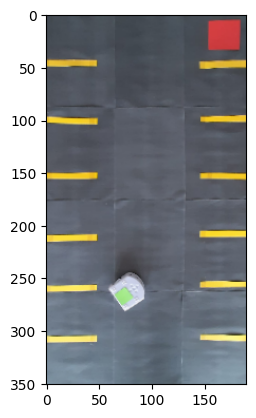

In [8]:
h, w = test2.shape[:2]
# Getting the homography.
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))
# Perspective transform using homography.
final = cv2.warpPerspective(test2, M, (destination_corners[2][0], destination_corners[2][1]), flags=cv2.INTER_LINEAR)
plt.imshow(final)
plt.show()

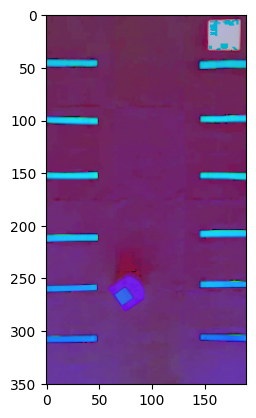

In [9]:
seg = final.copy()
seg = cv2.cvtColor(seg, cv2.COLOR_RGB2HSV)
plt.imshow(seg)
plt.show()

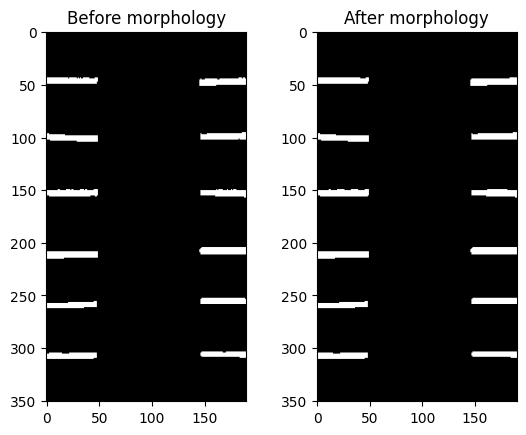

In [10]:
lower_yellow = np.array([22, 93, 0])
upper_yellow = np.array([45, 255, 255])

mask_yellow = cv2.inRange(seg, lower_yellow, upper_yellow)
kernel = np.ones((5, 5), np.uint8)
mask_yellow2 = cv2.dilate(mask_yellow, kernel)
mask_yellow2 = cv2.erode(mask_yellow2, kernel)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mask_yellow, cmap='gray')
ax1.set_title('Before morphology')
ax2.imshow(mask_yellow2, cmap='gray')
ax2.set_title('After morphology')
plt.show()

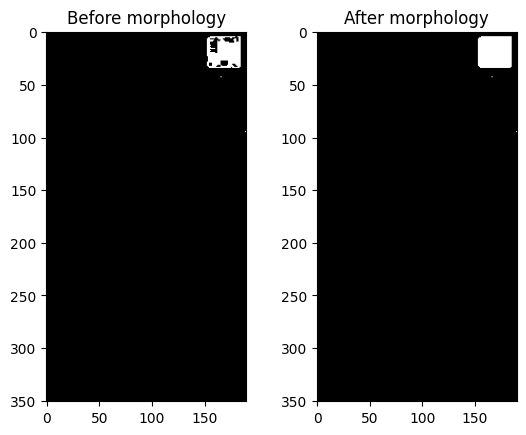

In [11]:
lower_red = np.array([155,25,0])
upper_red = np.array([179,255,255])

mask_red = cv2.inRange(seg, lower_red, upper_red)
kernel = np.ones((7, 7), np.uint8)
mask_red2 = cv2.dilate(mask_red, kernel)
mask_red2 = cv2.erode(mask_red2, kernel)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mask_red, cmap='gray')
ax1.set_title('Before morphology')
ax2.imshow(mask_red2, cmap='gray')
ax2.set_title('After morphology')
plt.show()

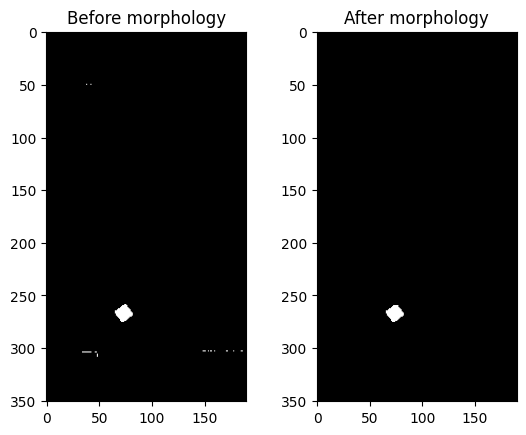

In [12]:
lower_green = np.array([36, 25, 25])
upper_green = np.array([70, 255,255])

mask_green = cv2.inRange(seg, lower_green, upper_green)
kernel = np.ones((3, 3), np.uint8)
mask_green2 = cv2.erode(mask_green, kernel)
mask_green2 = cv2.dilate(mask_green2, kernel)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(mask_green, cmap='gray')
ax1.set_title('Before morphology')
ax2.imshow(mask_green2, cmap='gray')
ax2.set_title('After morphology')
plt.show()

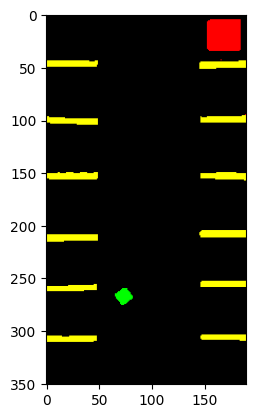

In [13]:
final_seg = np.zeros_like(final)
for i in range(final_seg.shape[0]):
    for j in range(final_seg.shape[1]):
        if mask_yellow2[i, j]:
            final_seg[i, j] = np.array([255, 255, 0])
        if mask_red2[i, j]:
            final_seg[i, j] = np.array([255, 0, 0])
        if mask_green2[i, j]:
            final_seg[i, j] = np.array([0, 255, 0])
cv2.imwrite('segmentation_colors.jpg', cv2.cvtColor(final_seg, cv2.COLOR_RGB2BGR))
plt.imshow(final_seg)
plt.show()

In [14]:
#cap = cv2.VideoCapture(1)
#ret, frame = cap.read()
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#plt.imshow(frame)
#plt.show()

In [41]:
def check_patch(patch):
    threshold = 200
    a,b = patch.shape
    for x in range(a):
        for y in range(b):
            if patch[x,y] > threshold:
                return True
    return False

def delete_outliers(data):
    main_data = []
    threshold = 2
    mean_x = np.mean(data[:,0])
    mean_y = np.mean(data[:,1])
    std_x = np.std(data[:,0])
    std_y = np.std(data[:,1])
    for point in data:
        z_score_x = abs(point[0] - mean_x) / std_x
        z_score_y = abs(point[1] - mean_y) / std_y
        if z_score_x < threshold and z_score_y < threshold:
            main_data.append([point[0], point[1]])
    return main_data

map_arr = final_seg
size_x, size_y, _ = map_arr.shape
kernel = 1

path_arr = np.zeros([size_x//(2*kernel+1), size_y//(2*kernel+1)], np.uint8)
end_patch = []
start_patch = []

for x in np.arange(kernel, size_x-kernel, 2*kernel+1):
    for y in np.arange(kernel, size_y-kernel, 2*kernel+1):
        path_pixel = (x//(2*kernel+1), y//(2*kernel+1))
        #path_pixel = (x,y)
        red_patch =   map_arr[x-kernel:x+kernel+1, y-kernel:y+kernel+1, 0]
        green_patch = map_arr[x-kernel:x+kernel+1, y-kernel:y+kernel+1, 1]
        blue_patch =  map_arr[x-kernel:x+kernel+1, y-kernel:y+kernel+1, 2]

        # check for red
        if   (check_patch(red_patch) and (not check_patch(green_patch)) and (not check_patch(blue_patch))):
            end_patch.append(list(path_pixel))
            path_arr[path_pixel] = 0
        # check for yellow
        elif (check_patch(red_patch) and (check_patch(green_patch)) and (not check_patch(blue_patch))):
            path_arr[path_pixel] = 1
        # check for white
        elif (check_patch(red_patch) and (check_patch(green_patch)) and (check_patch(blue_patch))):
            path_arr[path_pixel] = 1
        # check for blue
        elif ((not check_patch(red_patch)) and (not check_patch(green_patch)) and (check_patch(blue_patch))):
            path_arr[path_pixel] = 1
        # check for green
        elif ((not check_patch(red_patch)) and (check_patch(green_patch)) and (not check_patch(blue_patch))):
            start_patch.append(list(path_pixel))
            path_arr[path_pixel] = 0
        # free space
        else: path_arr[path_pixel] = 0

path_x, path_y = path_arr.shape

end_patch = np.array(end_patch)
end_patch = np.array(delete_outliers(end_patch))

goal_x = (min(end_patch[:,0])+max(end_patch[:,0]))//2
goal_y = (min(end_patch[:,1])+max(end_patch[:,1]))//2
goal = (goal_x, goal_y)

start_patch = np.array(start_patch)
start_patch = np.array(delete_outliers(start_patch))
start_x = (min(start_patch[:,0])+max(start_patch[:,0]))//2
start_y = (min(start_patch[:,1])+max(start_patch[:,1]))//2
start = (start_x, start_y)

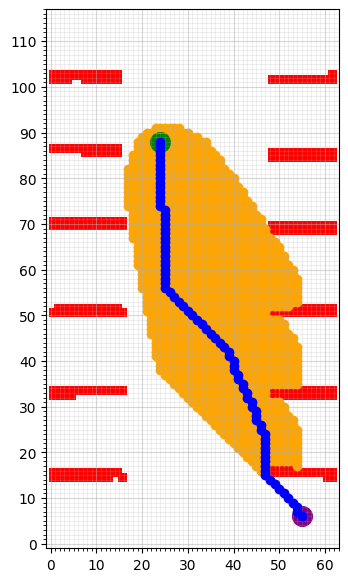

In [42]:
from pathfinding import *

x,y = np.mgrid[0:path_x:1, 0:path_y:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run A*
path, visitedNodes = A_Star(start, goal, h, coords, path_arr, movement_type="8N", max_val=path_arr.shape)
path = np.array(path).reshape(-1, 2)
visitedNodes = np.array(visitedNodes).reshape(-1, 2)

# Display map
cmap = colors.ListedColormap(['white', 'red'])
fig_astar, ax_astar = create_empty_plot((path_y, path_x))
ax_astar.imshow(path_arr, cmap=cmap)
ax_astar.scatter(visitedNodes[:,1], visitedNodes[:,0], marker="o", color = 'orange')
ax_astar.plot(path[:,1], path[:,0], marker="o", color = 'blue')
ax_astar.scatter(start[1], start[0], marker="o", color = 'green', s=200)
ax_astar.scatter(goal[1], goal[0], marker="o", color = 'purple', s=200)
plt.show()

In [ ]:
from control import ThymioControl
# import time

# image processing
# pathfinding
# start kalman, which calls image processing
# start path following
#print(path.T)
thymio = ThymioControl(position=(0,0), angle=0)
#path = [(200,200), (300,100), (0,0)]
thymio.set_path(path.T)
thymio.follow_path()